In [1]:
import warnings
warnings.filterwarnings("ignore")

# Parte 2: Modelo

De los resultados de búsqueda del search, se pueden obtener datos interesantes
sobre cada publicación: un campo valioso es el de ‘sold_quantity’ que hace referencia
al total de ventas históricas de un ítem.
Utilizando los datos de nuestras Apis públicas, el desafío es el de armar un dataset y
un modelo que permita predecir con atributos de la publicación el valor de
‘sold_quantity’.

Por ejemplo para el id = MLA842101865 el valor de sold_quantity es
250.

Te recomendamos empezar mirando estos servicios
- https://api.mercadolibre.com/sites/MLA/search?q=tv%204k
- https://api.mercadolibre.com/items/MLA842101865

El modelo a utilizar es libre y valoramos la comparación entre distintos
caminos.

¿Qué vamos a evaluar?

- Capacidad de generar el dataset
- Los features utilizados y el tipo de modelo
- El análisis de performance del modelo
- El código y las buenas prácticas de desarrollo.

Cargamos la data dispuesta en .json y luego la estructuramos como un pandas dataframe

In [2]:
import requests
r = requests.get('https://api.mercadolibre.com/sites/MLA/search?q=tv%204k')
my_dict = r.json()
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df=pd.DataFrame.from_dict(my_dict["results"])

In [3]:
df.head()

,id,site_id,title,seller,price,prices,sale_price,currency_id,available_quantity,sold_quantity,buying_mode,listing_type_id,stop_time,condition,permalink,thumbnail,thumbnail_id,accepts_mercadopago,installments,address,shipping,seller_address,attributes,original_price,category_id,official_store_id,domain_id,catalog_product_id,tags,catalog_listing,use_thumbnail_id,offer_score,offer_share,match_score,winner_item_id,melicoin,discounts,order_backend,differential_pricing
0,MLA1101839654,MLA,Smart Tv Sansei Tds2150ui Led 4k Uhd 50,"{'id': 256324891, 'permalink': 'http://perfil....",61999.0,"{'id': 'MLA1101839654', 'prices': [{'id': '22'...",None,ARS,22,526,buy_it_now,gold_special,2042-02-08T01:45:42.000Z,new,https://www.mercadolibre.com.ar/smart-tv-sanse...,http://http2.mlstatic.com/D_922576-MLA47150753...,922576-MLA47150753339_082021,True,"{'quantity': 12, 'amount': 8791.97, 'rate': 70...","{'state_id': 'AR-B', 'state_name': 'Buenos Air...","{'free_shipping': True, 'mode': 'me2', 'tags':...","{'id': '', 'comment': '', 'address_line': '', ...","[{'attribute_group_id': 'MAIN', 'attribute_gro...",76949.0,MLA1002,1372.0,MLA-TELEVISIONS,MLA18418092,"[extended_warranty_eligible, good_quality_pict...",True,True,None,None,None,None,None,None,1,NaN
1,MLA1131372433,MLA,Smart Tv Philips 7000 Series 50pud7406/77 Led ...,"{'id': 608846165, 'permalink': 'http://perfil....",83999.0,"{'id': 'MLA1131372433', 'prices': [{'id': '3',...",None,ARS,414,88,buy_it_now,gold_pro,2042-04-15T17:52:07.000Z,new,https://www.mercadolibre.com.ar/smart-tv-phili...,http://http2.mlstatic.com/D_745854-MLA48622828...,745854-MLA48622828334_122021,True,"{'quantity': 3, 'amount': 27999.67, 'rate': 0,...","{'state_id': 'AR-B', 'state_name': 'Buenos Air...","{'free_shipping': True, 'mode': 'me2', 'tags':...","{'id': '', 'comment': '', 'address_line': '', ...","[{'value_id': '3', 'value_name': 'Philips', 'n...",101999.0,MLA1002,1938.0,MLA-TELEVISIONS,MLA18607070,"[3x_campaign, extended_warranty_eligible, good...",True,True,None,None,None,None,None,None,2,{'id': 35713320}
2,MLA1121613092,MLA,Smart Tv LG Ai Thinq 43up7750psb Lcd 4k 43 10...,"{'id': 304956690, 'permalink': 'http://perfil....",66692.0,"{'id': 'MLA1121613092', 'prices': [{'id': '33'...",None,ARS,4,98,buy_it_now,gold_special,2042-01-27T04:00:00.000Z,new,https://www.mercadolibre.com.ar/smart-tv-lg-ai...,http://http2.mlstatic.com/D_753214-MLA48707187...,753214-MLA48707187900_122021,True,"{'quantity': 12, 'amount': 9457.48, 'rate': 70...","{'state_id': 'AR-C', 'state_name': 'Capital Fe...","{'free_shipping': True, 'mode': 'me2', 'tags':...","{'id': '', 'comment': '', 'address_line': '', ...","[{'value_id': '215', 'value_name': 'LG', 'valu...",NaN,MLA1002,NaN,MLA-TELEVISIONS,MLA18505212,"[extended_warranty_eligible, good_quality_pict...",True,True,None,None,None,None,None,None,3,NaN
3,MLA1132660367,MLA,Smart Tv Noblex Dm50x7550 Led 4k 50 220v,"{'id': 9877009, 'permalink': 'http://perfil.me...",70199.9,"{'id': 'MLA1132660367', 'prices': [{'id': '2',...",None,ARS,29,13,buy_it_now,gold_special,2042-04-13T04:00:00.000Z,new,https://www.mercadolibre.com.ar/smart-tv-noble...,http://http2.mlstatic.com/D_818430-MLA48622921...,818430-MLA48622921396_122021,True,"{'quantity': 12, 'amount': 9954.93, 'rate': 70...","{'state_id': 'AR-C', 'state_name': 'Capital Fe...","{'free_shipping': True, 'mode': 'me2', 'tags':...","{'id': '', 'comment': '', 'address_line': '', ...","[{'values': [{'id': '9807', 'name': 'Noblex', ...",NaN,MLA1002,NaN,MLA-TELEVISIONS,MLA17546860,"[extended_warranty_eligible, good_quality_pict...",True,True,None,None,None,None,None,None,4,NaN
4,MLA1121941659,MLA,Smart Tv LG Ai Thinq 50up7750psb Lcd 4k 50 10...,"{'id': 131846678, 'permalink': 'http://perfil....",82999.0,"{'id': 'MLA1121941659', 'prices': [{'id': '15'...",None,ARS,7,88,buy_it_now,gold_special,2042-01-28T04:00:00.000Z,new,https://www.mercadolibre.com.ar/smart-tv-lg-ai...,http://http2.mlstatic.com/D_965528-MLA48699699...,965528-MLA48699699934_122021,True,"

La información corresponde a una búsqueda realizada en Meli versión Argentina de “tv 4k”. Esta búsqueda arrojó 2208 resultados, de los cuáles solo analizaremos los primeros 50 (de acuerdo a relevancia).

In [4]:
df_tm=((((df.isnull().sum()>0) & (df.isnull().sum()<50)) | (df.isnull().sum()==0) ).reset_index())
name_1=df_tm[df_tm.iloc[:,1]==True].iloc[:,0]
df_1=df[name_1]

A partir features existentes, vamos a crear otras para complementar el análisis:

In [5]:
import numpy as np
#Si el producto tiene descuento en el precio original.
df_1['discount'] = np.where(df_1['original_price'].isnull(),0,1)

#Porcentaje de unidades vendidas del producto.
df_1['porc_sold'] = df_1['sold_quantity']/(df_1['available_quantity'] + df_1['sold_quantity'])*100.00

#Porcentaje de descuento en el precio del producto.
df_1['P_discount'] = (df_1.original_price-df_1.price)/df_1.original_price*100

In [6]:
from pandas import json_normalize

df_t2 = json_normalize(df_1.installments, max_level=0)
df_1 = pd.merge(df_1,df_t2,left_index=True,right_index=True,how='inner')

df_t3 = json_normalize(df_1.address, max_level=0)
df_1 = pd.merge(df_1,df_t3,left_index=True,right_index=True,how='inner')

df_t6=0
for i in range(50):
    if i==0:
        a1=json_normalize(df_1.attributes[i], max_level=0)[['id','name','value_name']]
        df_t6=(a1[(a1.id=='PACKAGE_LENGTH') | (a1.id=='PACKAGE_WEIGHT') | (a1.id=='WEIGHT')][['name','value_name']].set_index(
            'name',inplace=False)).transpose()
    else:
        a1=json_normalize(df_1.attributes[i], max_level=0)[['id','name','value_name']]
        at=(a1[(a1.id=='PACKAGE_LENGTH') | (a1.id=='PACKAGE_WEIGHT') | (a1.id=='WEIGHT')][['name','value_name']].set_index(
            'name',inplace=False)).transpose()
        df_t6 = pd.concat([df_t6,at],axis=0)
        
tmp=(df_t6.reset_index().drop(['index'],axis=1))
tmp.Peso=(pd.Series(tmp.Peso).replace(to_replace='kg', value='',inplace=False,regex=True).values).astype("float64")
tmp['Largo del paquete']=(pd.Series(tmp['Largo del paquete']).replace(to_replace='cm', value='',inplace=False,regex=True
                                                                     ).values).astype("float64")
tmp['Peso del paquete']=(pd.Series(tmp['Peso del paquete']).replace(to_replace='g', value='',inplace=False,regex=True).values
                        ).astype("float64")

df_1 = pd.merge(df_1,(tmp.reset_index().drop(['index'],axis=1)),left_index=True,right_index=True,how='inner')
df_1[['discount','price','available_quantity','sold_quantity','original_price','porc_sold','P_discount','quantity','amount',
      'Peso','Largo del paquete','Peso del paquete']] = df_1[['discount','price','available_quantity','sold_quantity',
                                                              'original_price','porc_sold','P_discount','quantity','amount',
                                                              'Peso','Largo del paquete','Peso del paquete']].fillna(0)

In [7]:
df_1['sold_quantity_decil'] = pd.qcut(df_1['sold_quantity'], 10, labels=False)

In [8]:
df_1['state_name_BuenosAires']=np.where(df_1.state_name=='Buenos Aires',1,0)
df_1['state_name_CapitalFederal']=np.where(df_1.state_name=='Capital Federal',1,0)
df_1['state_name_Tucuman']=np.where(df_1.state_name=='Tucumán',1,0)
df_1['state_name_SantaFe']=np.where(df_1.state_name=='Santa Fe',1,0)
df_1=df_1.fillna(0)

In [9]:
df_1[['price','available_quantity','original_price','porc_sold','P_discount','quantity',
      'amount','Peso','Largo del paquete','Peso del paquete','sold_quantity_decil']].groupby(['sold_quantity_decil']).describe()

price                                                                                available_quantity                                                           original_price                                                                    porc_sold                                                                              P_discount                                                                  quantity                                                 amount                                                                                     Peso                                                         Largo del paquete                                                Peso del paquete                                                              
                    count           mean            std      min       25%       50%       75%       max              count        mean         std  min     25%    50%    75%    max          count          mean           std  min  25%      50%       75%       max     count       mean        std        min        25%        50%        75%        max      count       mean        std  min  25%        50%        75%        max    count   mean       std   min    25%   50%   75%   max  count          mean           std       min         25%        50%         75%       max count    mean        std   min     25%     50%      75%   max             count   mean        std  min  25%   50%    75%   max            count         mean          std  min  25%     50%      75%      max
sold_quantity_decil                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
0                     5.0  136002.600000   94581.923148  76999.0  78199.00   90590.0  134226.0  299999.0                5.0   12.000000   15.921683  2.0    2.00    3.0   14.0   39.0            5.0      0.000000      0.000000  0.0  0.0      0.0       0.0       0.0       5.0  12.166667  15.828947   0.000000   0.000000   2.500000  25.000000  33.333333        5.0   0.000000   0.000000  0.0  0.0   0.000000   0.000000   0.000000      5.0  12.00  0.000000  12.0  12.00  12.0  12.0  12.0    5.0  19286.304000  13412.505233  10919.10  11089.2700  12846.420  19034.3700  42542.36   5.0  15.410   6.136815   9.5  10.250  14.900  17.9000  24.5               5.0   0.00   0.000000  0.0  0.0   0.0   0.00   0.0              5.0     0.000000     0.000000  0.0  0.0     0.0      0.0      0.0
1                     5.0   75819.200000   12619.779721  64599.0  65999.00   69500.0   88999.0   89999.0                5.0  103.600000  101.579033  2.0    2.00  111.0  175.0  228.0            5.0  18999.800000  42484.844359  0.0  0.0      0.0       0.0   94999.0       5.0  27.010698  33.258597   1.298701   2.777778   4.310345  60.000000  66.666667        5.0   1.263171   2.824537  0.0  0.0   0.000000   0.000000   6.315856      5.0  12.00  0.000000  12.0  12.00  12.0  12.0  12.0    5.0   9710.952000   1938.054909   7416.58   9160.6800   9359.210   9855.6800  12762.61   5.0  10.780   1.477159   9.1   9.600  11.000  11.4000  12.8               5.0   3.08   6.887089  0.0  0.0   0.0   0.00  15.4              5.0  3036.000000  6788.702380  0.0  0.0     0.0      0.0  15180.0
2                     5.0   91210.800000   18863.113720  78000.0  81599.00   82583.0   89799.0  124073.0                

A partir del análisis exploratorio hecho en la parte 1, consideraré esas features para realizar el modelo pedido. Mencionar, que en este caso realizaré un modelo exploratorio no predictivo, es decir, que solo quiero explicar los datos por medio de un modelo pero donde su objetivo no es predecir y usar la herramienta tal como está. (Esto básicamente porque tanto la variable objetivo como las variables del set están en la misma época).

El modelo que se pide es de regresión a una variable discreta o de conteo, que en este caso es la feature "sold_quantity". Lo primero que haremos, es analizar la esta variable de forma univariada y luego procederemos a hacer un análisis multivariado con las demas features.

### Análisis Univariado

count     50.000000
mean      87.640000
std      151.056654
min        0.000000
25%        6.250000
50%       23.500000
75%       85.500000
max      582.000000
Name: sold_quantity, dtype: float64


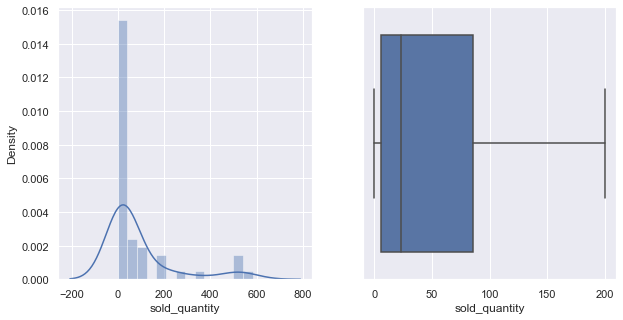

In [10]:
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
sns.set(rc={"figure.figsize":(10, 5)})
fig, axes = plt.subplots(1, 2)
sns.distplot(df_1.sold_quantity,ax=axes[0])
sns.boxplot(df_1.sold_quantity,showfliers=False, orient="h",ax=axes[1])
print(df_1.sold_quantity.describe())

Lo que puede observar es que como es una variable de conteo es que su rango de datos es de valores enteros positivos. Además, tiene una gran cantidad de valores cercanos a cero.

### Análisis bivariado

Realizamos la matriz de correlaciones entre features continuas y categóricas

In [11]:
corr_matrix=(df_1[['sold_quantity','price','available_quantity','original_price','porc_sold','P_discount','quantity',
       'amount','Peso','Largo del paquete','Peso del paquete','state_name_BuenosAires','state_name_CapitalFederal',
                   'state_name_Tucuman','state_name_SantaFe','discount']]).corr(method='spearman')

<AxesSubplot:>

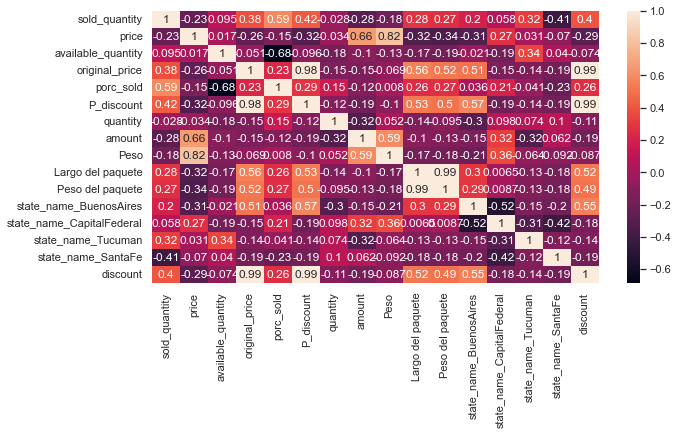

In [12]:
sns.heatmap(corr_matrix, annot=True)

Cada feature se comparó con la variable objetivo (sold_quantity). Aquellas features que tienen una correlación mayor a .35 son: original_price, porc_sold, P_discount, state_name_SantaFe y discount.

<AxesSubplot:>

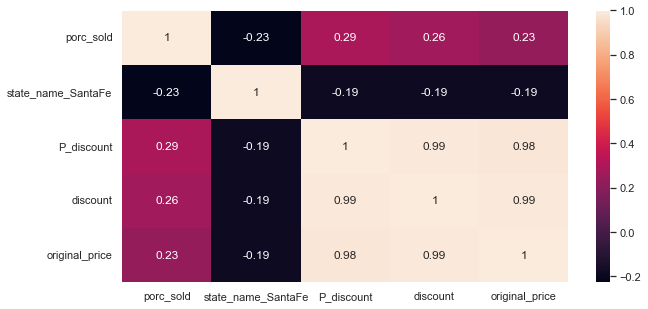

In [13]:
corr_matrix_1=(df_1[['porc_sold','state_name_SantaFe','P_discount','discount','original_price']]).corr(method='spearman')
sns.heatmap(corr_matrix_1, annot=True)

Debido a una gran cantidad de correlación (debido a la forma de construcción) entre P_discount, discount y original_price, dejaremos P_discount por la alta correlación que tiene con sold_quantity.

Por lo tanto, nos quedaremos con estas variables para hacer el modelo requerido:
- porc_sold
- state_name_SantaFe
- P_discount

### Muestra de entrenamiento

Como estamos construyendo un modelo exploratorio, podemos usar la muestra por completo.

In [14]:
data=df_1[['id','porc_sold','state_name_SantaFe','P_discount','sold_quantity']]

### Creación modelos

Debido al tipo de problema propuesto, los modelos para utilizar son supervisados con variable objetivo de conteo:
- Regresión de Poisson
- Regresión Binomial Negativa

In [15]:
import numpy as np
import pandas as pd
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.cov_struct import (Exchangeable,
    Independence,Autoregressive)
from statsmodels.genmod.families import Poisson,NegativeBinomial
from sklearn.metrics import r2_score

In [18]:
fam = Poisson()
ind = Independence()
model1 = GEE.from_formula("sold_quantity ~ porc_sold + state_name_SantaFe + P_discount", "id", data, cov_struct=ind, family=fam)
result1 = model1.fit()
print(result1.summary())

                               GEE Regression Results                              
Dep. Variable:               sold_quantity   No. Observations:                   50
Model:                                 GEE   No. clusters:                       50
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   1
Family:                            Poisson   Mean cluster size:                 1.0
Dependence structure:         Independence   Num. iterations:                     1
Date:                     Mon, 02 May 2022   Scale:                           1.000
Covariance type:                    robust   Time:                         01:30:45
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              3.3427      0.454      7.364      0.000       2

In [19]:
print(result1.deviance)
print(result1.aic)

5455.682698677003
5709.129717528424


In [20]:
a1=result1.get_prediction(data[['porc_sold','state_name_SantaFe','P_discount']])

In [21]:
np.corrcoef(a1.predicted_mean,data['sold_quantity'])[0][1]

0.5554733537115316

In [22]:
fam = NegativeBinomial()
ind = Independence()
model2 = GEE.from_formula("sold_quantity ~ porc_sold + state_name_SantaFe + P_discount", "id", data, cov_struct=ind, family=fam)
result2 = model2.fit()
print(result1.summary())

                               GEE Regression Results                              
Dep. Variable:               sold_quantity   No. Observations:                   50
Model:                                 GEE   No. clusters:                       50
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   1
Family:                            Poisson   Mean cluster size:                 1.0
Dependence structure:         Independence   Num. iterations:                     1
Date:                     Mon, 02 May 2022   Scale:                           1.000
Covariance type:                    robust   Time:                         01:30:50
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              3.3427      0.454      7.364      0.000       2

In [23]:
print(result2.deviance)
print(result2.aic)

86.23676397982132
508.03789933203007


In [24]:
a2=result2.get_prediction(data[['porc_sold','state_name_SantaFe','P_discount']])

In [25]:
np.corrcoef(a2.predicted_mean,data['sold_quantity'])[0][1]

0.550053092435309

### Performance y elección de modelo

- En ambos modelos, los parámetros son significativos con 5% de significancia
- Para analizar la performance utilizamos 2 criterios: Devianza, AIC (estos se fijan en la bondad de ajuste) y correlación de variable objetivo con variable predicha.
- Estos son los resultados:

| Modelo | Devianza | AIC | Corr |
| --- | --- | --- | --- |
| Regresión Poisson | 5456 | 5709 | 0.56 |
| Regresión Binomial Negativa | 86 | 508 | 0.55 |

- En devianza y aic el modelo de regresión BN son más pequeños que el de Poisson. Esto nos habla que se ajusta mejor a las respectiva distribución propuesta y por lo tanto, si quisiera predecir es una buena aproximación.
- En términos de la correlación, en ambos casos es sobre 0.5. Nos habla de que la predicción se relaciona con la respuesta real.